## Text Mining by Word Representation

### 任务描述

本次实验需要针对一百万篇疫情相关论文进行文本挖掘。具体的，根据用户提供的问句进行内容检索，并以适当形式展示。

在进行相关调研之后，我把该任务定义为“机器阅读理解之多答案抽取任务”。


### 实验流程

<div align=center>
<img src="pic\图片1.png" style="zoom:20%" />
</div>

上图展示了本次实验的实验流程。具体的，本次实验分为**离线特征构建**和**在线问答**两个部分，对于前者主要针对原始数据进行分析、清洗以及特征预处理，运行一次后变无需再次运行。对于后者完成文献的检索和问答工作，其中检索分为**粗筛**和**精筛**。粗筛使用**哈希局部敏感算法**返回500篇文章，再将问题和文章进行**向量化**表示，计算余弦相似度排序，返回前100篇文章。最终，对这100篇文章（包含题目、摘要和全文）进行问答。其中，向量化表示和问答均使用**bio-bert模型**。

### 实验过程

#### 1. 导入第三方库

In [1]:
import numpy as np 
import pandas as pd
import json
import os
from langdetect import detect #轻量级语言检测库
import torch
from transformers import  AutoTokenizer,AutoModelForQuestionAnswering #使用huggingface的transformer
from datetime import datetime
import matplotlib.pyplot as plt
import operator
import seaborn as sns # matplotlib二次封装的绘图库
from wordcloud import WordCloud # 词云绘图库
import collections
from datasketch import MinHash, MinHashLSHForest # 哈希局部敏感算法库
from biobert_embedding.embedding import BiobertEmbedding # huggingface的biobert
import torch

plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体，保证matplotlib可以显示中文
%matplotlib inline

from warnings import filterwarnings
filterwarnings("ignore")

e:\anaconda\envs\biobert\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 2、数据探索

##### 2.1 读入数据

In [2]:
# 装载数据
df=pd.read_csv('G:/Text_mining/src/metadata.csv', usecols=['title','journal','abstract','authors','doi','publish_time','sha'])
# 填充缺省值
df=df.fillna('N/A')
print(df.shape)
df.head(5)

(1015768, 7)


,sha,title,doi,abstract,publish_time,authors,journal
0,d1aafb70c066a2068b02786f8929fd9c900897fb,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis
1,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res
2,06ced00a5fc04215949aa72528f2eeaae1d58927,Surfactant protein-D and pulmonary host defense,10.1186/rr19,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res
3,348055649b6b8cf2b9a376498df9bf41f7123605,Role of endothelin-1 in lung disease,10.1186/rr44,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res
4,5f48792a5fa08bed9f56016f4981ae2ca6031b32,Gene expression in epithelial cells in respons...,10.1186/rr61,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res


##### 2.2 观察论文发表年份

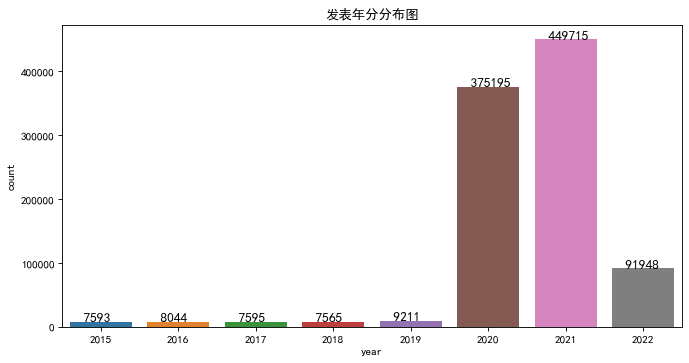

In [3]:
time = {}

for index, row in df.iterrows():
    date = row['publish_time']
    if date == 'N/A':
        publish = 'N/A'
    elif date.find("-") != -1:
        publish = datetime.strptime(date, "%Y-%m-%d").strftime("%Y")
    else:
        publish = datetime.strptime(date, "%Y").strftime("%Y")

    if publish not in time:
        time[publish] = 1
    else:
        time[publish] += 1

publish_time = []
for key,value in time.items():
    if key == "N/A" or eval(key)>2022 or eval(key)<2015:
        continue
    for i in range(time[key]):
        publish_time.append([key,time[key]])
publish_time = pd.DataFrame(publish_time,columns = ['year','numbers'])

fig,ax = plt.subplots(figsize=(10,5), dpi=80)
ax.set_title("发表年分分布图")
sns.countplot(data=publish_time,x='year')
for p in ax.patches:
    ax.annotate(f'  {p.get_height()}', (p.get_x(), p.get_height()+80), color='black', size=12)
plt.show()



从结果可以看到，相关论文在2020年以后呈爆发式增长，增长幅度超过3000%。

可以看到尽管22年刚刚过去5个月，今年发表的相关论文已经达到近十万篇。

##### 2.3 观察论文来源

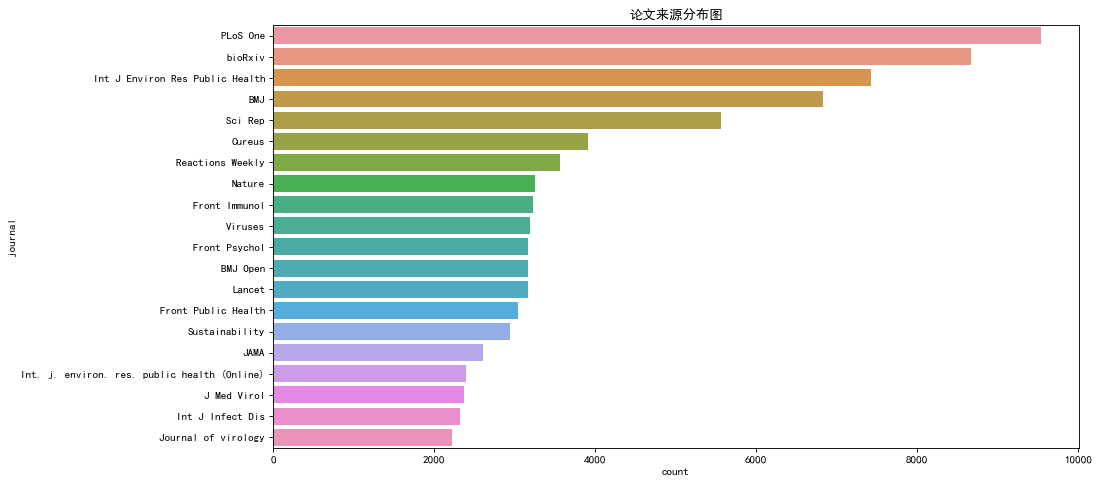

In [4]:
journal = {}

for index, row in df.iterrows():
    paper_from = row['journal']

    if paper_from not in journal:
        journal[paper_from] = 1
    else:
        journal[paper_from] += 1

journal1 = dict(sorted(journal.items(), key=operator.itemgetter(1),reverse=True))
num=0
paper_from = []
for key,value in journal1.items():
    if key == "N/A":
        continue
    num+=1
    for i in range(journal1[key]):
        paper_from.append([key,journal[key]])
    if num==20:
        break
paper_from = pd.DataFrame(paper_from,columns = ['journal','numbers'])  

fig,ax = plt.subplots(figsize=(13,7), dpi=80)
ax.set_title("论文来源分布图")
sns.countplot(data=paper_from,y='journal')
plt.show()

其中Plos One来源数目最多，据调查PLoS（美国科学公共图书馆的简称）是系列期刊中的综合性开源期刊，于2006年创刊在线出版论文，刊载一切科学与医学领域的有价值的成果。

##### 2.4 生成词云

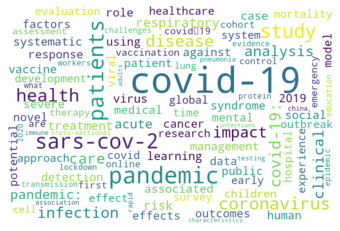

In [5]:
result_list = []
# 去除停用词和重复词
stopwords = ['on','in','by','and','be','of','the','for','a','an','with','A','The','during','from','as','de','among','review','With','-','An','la','New','en'
    ,'to','at','2','How','is','or','between','From','Case','use','Use','through','Among','new','Is','Using','During','after', 'Review','report','based','In'
    ,'its','(COVID-19)','covid-19:']

for index, row in df.iterrows():
    title = row['title'].split()
    for word in title:
        if word in stopwords:
            continue
        result_list.append(word.lower()) # 只要小写


# 筛选后统计
word_counts = collections.Counter(result_list)
# 获取前100最高频的词
word_counts_top100 = word_counts.most_common(120)

# 绘制词云
my_cloud = WordCloud(
    background_color='white',  # 设置背景颜色  默认是black
    width=900, height=600,
    max_words=100,            # 词云显示的最大词语数量
    max_font_size=99,         # 设置字体最大值
    min_font_size=16,         # 设置子图最小值
    random_state=50           # 设置随机生成状态，即多少种配色方案
).generate_from_frequencies(word_counts)

# 显示生成的词云图片
plt.imshow(my_cloud, interpolation='bilinear')
# 显示设置词云图中无坐标轴
plt.axis('off')
plt.show()

文章题目的词云图如上（已进行停词和重复词去除），可以看到covid-19和sars-cov-2这两个词出现最多，其次如pandemic、impact、clinical等疫情相关词汇出现也比较多。

#### 3.数据清洗

这部分主要包括：

- 保留'conv'相关论文
  - by 字符匹配
- 保留2020年及以后表表的论文
  - by Dataframe遍历筛选
- 数据去重
  - by drop_duplicates()函数
- 字符转小写
  - by str.lower()
- 检索条件相关
  - by 字符串检索: str.find()
- 去除非英文文献
  - by langdetect第三方库
- 去停词和标点符号
  - 停词来源：https://blog.csdn.net/shijiebei2009/article/details/39696523 (不能删数字)

##### 3.1 年份和标题清洗

In [6]:
def search_focus(df):
    '''
    仅保留包含关键词语的论文
    '''
    dfa = df[df['abstract'].str.contains('covid')]
    dfb = df[df['abstract'].str.contains('-cov-2')]
    dfc = df[df['abstract'].str.contains('cov2')]
    dfd = df[df['abstract'].str.contains('ncov')]
    frames=[dfa,dfb,dfc,dfd]
    df = pd.concat(frames)
    df=df.drop_duplicates(subset='title', keep="first")
    return df

def year_focus(df):
    '''
    仅保留2020年及以后的论文
    '''
    dfa = df[df['publish_time'].str.contains('2020')]
    dfb = df[df['publish_time'].str.contains('2021')]
    dfc = df[df['publish_time'].str.contains('2022')]
    frames=[dfa,dfb,dfc]
    df = pd.concat(frames)
    df=df.drop_duplicates(subset='title', keep="first")
    return df 
    
print("原有数据：",df.shape)
# 数据去重
df = df.drop_duplicates(subset='title', keep="first")
# df = df.drop_duplicates(subset='sha', keep="first")
# 将字符变小写
df["abstract"] = df["abstract"].str.lower()
df["title"] = df["title"].str.lower()
df = search_focus(df)
df = year_focus(df)
print("数据清洗后：",df.shape)
# 数据展示
df.head(5)

原有数据： (1015768, 7)
数据清洗后： (352435, 7)


,sha,title,doi,abstract,publish_time,authors,journal
8201,04383994da0f349f314e59c9a414a9c8cc5b4448,baricitinib - a januase kinase inhibitor - not...,10.1016/j.ijantimicag.2020.105967,• several studies suggested baricitinib as a p...,2020-04-04,"Praveen, D.; Chowdary, Puvvada Ranadheer; Aana...",Int J Antimicrob Agents
10710,N/A,artificial intelligence (ai) applications for ...,10.1016/j.dsx.2020.04.012,background and aims: healthcare delivery requi...,2020-04-14,"Vaishya, Raju; Javaid, Mohd; Khan, Ibrahim Hal...",Diabetes Metab Syndr
10822,322478c3c7cc2498a928597f28aea6c0aa39c5ea,coronavirus disease: challenges for psychiatry,10.1192/bjp.2020.86,coronavirus disease (covid-19) presents two ur...,2020-04-15,"Kelly, Brendan D.",N/A
10846,d049cc13cfc0854eef6913f1c11eece8792b89fc,practical considerations when performing neuro...,10.1080/21646821.2020.1756132,"the coronavirus disease 2019, sars-cov-2 (the ...",2020-05-06,"Haines, Seline; Caccamo, Amy; Chan, Fonda; Gal...",Neurodiagn J
11573,83f1f588d9b4176873e39dfe0fd3e4db7bb0161e,extracorporeal life support organization coron...,10.1097/mat.0000000000001193,the extracorporeal life support organization (...,2020-05-12,"Shekar, Kiran; Badulak, Jenelle; Peek, Giles; ...",ASAIO J


##### 3.2 将文献的标题和摘要合并

In [7]:
all_related_paper = []
for index, row in df.iterrows():
    sentences = row['abstract']+row['title']
    all_related_paper.append([row['sha'],sentences])
# print(all_related_paper)

all_related_paper = pd.DataFrame(all_related_paper,columns = ['sha','abstract'])
all_related_paper = all_related_paper.drop_duplicates(subset='abstract', keep="first")
print("预处理完毕")
all_related_paper.head(5)

预处理完毕


,sha,abstract
0,04383994da0f349f314e59c9a414a9c8cc5b4448,• several studies suggested baricitinib as a p...
1,N/A,background and aims: healthcare delivery requi...
2,322478c3c7cc2498a928597f28aea6c0aa39c5ea,coronavirus disease (covid-19) presents two ur...
3,d049cc13cfc0854eef6913f1c11eece8792b89fc,"the coronavirus disease 2019, sars-cov-2 (the ..."
4,83f1f588d9b4176873e39dfe0fd3e4db7bb0161e,the extracorporeal life support organization (...


##### 3.3 针对所有文本进行特征构建

在pdf_json文件中提供了众多已经标注好全文的数据，将其相关文章的全文提取出来，并进行特征构建。

但是，在处理过程中我发现使用全部文章内容并不是一个好的选择。下图展示了一篇医疗文献的各小节标题：


<div align=center>
<img src="pic\图片2.png" style="zoom:80%" />
</div>

由于医学文献和计算机相关文献写作风格迥异，小节标题也不是按照“引言”、“相关工作”、“方法”、“结论”等我认知的格式进行文章撰写。而且由于本次任务为问答，而待问答段落的质量也决定问答的好坏，因此我设置在["ABSTRACT","CONCLUSION","METHOD","INFECT","EFFECT","FACTOR","ANALY","DIFFER","RESULT"]段落中进行问答，舍弃其他段落。选择这些段落的原因很简单，这些段落中强调本篇文献获得的结果概率比较高。

匹配方法是首先将题目大写，并寻找上述关键词是否出现在标题中，若出现则使用。匹配举例如下：

<div align=center>
<img src="pic\图片3.png" style="zoom:20%" />
</div>

In [8]:
def format_body(body_text):
    '''获得文章的全部文本'''
    texts = [(di['section'], di['text']) for di in body_text]
    texts_di = {di['section']: "" for di in body_text}
    
    for section, text in texts:
        texts_di[section] += text

    body = ""

    # 需要的段落
    need = ["ABSTRACT","CONCLUSION","METHOD","INFECT","EFFECT","FACTOR","ANALY","DIFFER","RESULT"]

    for section, text in texts_di.items():
        
        flag = 0
        for ne in need:
            if section.upper().find(ne)!=-1: # 将文献小节题目大写
                flag = 1
                break
        if flag:
            body += section # ABSTRACT,BACKGROUND,CASE,CONCLUSION,DISSCUSION, etc.
            body += " "
            body += text
            body += "\n\n"
        
    
    return body

Candidate_articles = []


for index, row in all_related_paper.iterrows():
    # 如果文本有全文，则使用全文
    if 'N/A' not in row['sha'] and os.path.exists('pdf_json/'+row['sha']+'.json')==True:
        with open('pdf_json/'+row['sha']+'.json') as json_file:
            data = json.load(json_file)
            body=format_body(data['body_text'])
            try:
                if detect(body) != 'en': # 只保留英文文本
                    continue
                # print(body)
                Candidate_articles.append([row['sha'],row['abstract'],body])
            except:
                pass
    # 否则只使用文献标题+摘要
    else:
        Candidate_articles.append([row['sha'],row['abstract'],row['abstract']])

Candidate_articles = pd.DataFrame(Candidate_articles,columns = ['sha','abstract','text'])
print("全文预处理完毕")
Candidate_articles.head(5)

全文预处理完毕


,sha,abstract,text
0,N/A,background and aims: healthcare delivery requi...,background and aims: healthcare delivery requi...
1,d049cc13cfc0854eef6913f1c11eece8792b89fc,"the coronavirus disease 2019, sars-cov-2 (the ...",CONCLUSIONS These are trying times presenting ...
2,83f1f588d9b4176873e39dfe0fd3e4db7bb0161e,the extracorporeal life support organization (...,Infection Control and Staff Safety The modes o...
3,670f5fc39bbb8591f12fbd8b4192ca3f12dd8791,objective: the coronavirus disease 2019 (covid...,METHODS A retrospective review of the imaging ...
4,e03ae7fce133152166d6d9f4486dc1668a1e0d7b,"as a global crisis, covid-19 has underscored t...",Conclusions: a new role for creative communica...


##### 3.4 去掉停用词和标点符号

In [9]:
def drop_stopwords(sentence):
    '''去掉停用词\n
    保留了old等
    '''
    stopwords = []
    with open('stopwords.txt','r',encoding='utf-8') as fr:
        for i in fr:
            stopwords.append(i.strip())
    result = ''
    for char in sentence.split(" "):
        if char not in stopwords:
            result = result + char+" "
    return result

In [10]:
def removepunc(my_str):
    '''去掉标点符号'''
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char
    return no_punct

#### 3.特征筛选

具体的，使用局部哈希敏感算法选取候选文章，再使用biobert embedding返回前K个最相似文章

##### 3.1 LSH特征构建和文献粗筛

需要说明这里只是用了文献的题目+摘要作为特征词库构建，原因如下：
- 该部分包含了文章的关键信息
- 减少了检索规模，节约时间

In [11]:
#排列
permutations = 128

def get_forest(data, perms):
    
    minhash = []
    
    for text in data['abstract']:
        tokens = removepunc(drop_stopwords(text))
        m = MinHash(num_perm=perms)
        for s in tokens.split(" "):
            m.update(s.encode('utf8'))
        minhash.append(m)
        
    forest = MinHashLSHForest(num_perm=perms)
    
    for i,m in enumerate(minhash):
        forest.add(i,m)
        
    forest.index()
    
    return forest

In [12]:
%%time
forest = get_forest(Candidate_articles, permutations)

Wall time: 17min 40s


In [13]:
def predict(text, database, perms, num_results, forest):

    tokens = removepunc(drop_stopwords(text))
    m = MinHash(num_perm=perms)
    for s in tokens.split(" "):
        m.update(s.encode('utf8'))

    idx_array = np.array(forest.query(m, num_results))
    if len(idx_array) == 0:
        return None # 如果问题为空，则返回None

    result = database.iloc[idx_array]['text']
    
    return result

提问并检索

In [14]:
# 在此提问
Question = 'What do we know about risk factors?'

In [15]:
%%time
num_recommendations = 500
Q = removepunc(drop_stopwords(Question))
result = predict(Q, Candidate_articles, permutations, num_recommendations, forest)
print('\n Top Recommendation(s) is(are) \n', result)


 Top Recommendation(s) is(are) 
 247810    Analysis of the factors affecting population f...
124939    this study aimed to illuminate the implication...
63514     this study aimed to determine the interface be...
141341    the covid-19 pandemic has significantly reshap...
321567    Data Analysis Based on the complex survey desi...
                                ...                        
94188     objectives: this study aimed to examine the as...
298991    CONCLUSIONS CRS is a clinical syndrome which h...
229359    as the covid-19 outbreak traveled through vari...
42995     background: acute type a aortic dissection (at...
176124    covid-19 has had a disproportionate impact on ...
Name: text, Length: 500, dtype: object
Wall time: 8 ms


根据问题反馈的500篇文章检索如上

In [16]:
# print(the_most_related_paper)
recommendations=[]
for index,value in result.iteritems():
    recommendations.append(value)
print("")
recommendations[0]

'Analysis of the factors affecting population flow networks Urban populations in or around the provinces migrate to provincial capital cities or regional cities. Large cities have a strong gravitational force and a large range of influence, affecting regional urban population migration. Figure During-Lockdown, the government strictly controlled population movement, but the demand for employment and for the return of people who travelled before the Spring Festival was urgent, and the migration of urban populations where the pandemic was not serious was still active.In Post-Lockdown, migration was affected by the number of COVID-19infections. In cities with the severe COVID-19 numbers, control measures were more strict, the resumption rates lower, and the corresponding population migration was lower. In addition, population migration in small cities dispersed over time, while the immigration and emigration of the population between large cities offset each other, and urban population inf

##### 3.2 使用biobert进行re-ranking

biobert安装来自网址：https://pypi.org/project/biobert-embedding/

In [17]:
biobert = BiobertEmbedding()

query_vector = biobert.sentence_vector(Q)

# 这里输出1是因为我改了一下源码，调试时候输出1，结果忘记改在哪了-_-
print("问句编码结果如下：")
query_vector

1
问句编码结果如下：


tensor([ 5.0620e-01, -1.5032e-01, -1.1204e-01, -1.4333e-01, -7.5077e-02,
         1.1758e-01,  4.4581e-01,  3.8233e-01,  2.4281e-01, -3.6569e-01,
        -1.8751e-01,  3.3460e-01, -6.1388e-01,  9.0671e-02, -5.8183e-01,
         1.6712e-02, -1.0591e-01, -1.4329e-01,  3.0434e-01, -1.1389e-01,
        -2.0389e-01, -5.7575e-01,  1.1411e-01, -2.6257e-01, -1.1406e-01,
         2.6154e-02,  9.4700e-02,  4.1450e-01, -1.5682e-01,  8.9968e-01,
        -2.4895e-01,  2.6722e-01, -2.3669e-01,  2.8881e-01, -3.1537e-01,
        -1.5317e-01,  5.3776e-02,  2.9761e-01, -2.9380e-01,  3.8691e-02,
        -2.0714e-01, -2.7725e-01,  5.2208e-01,  1.7243e-01,  9.5906e-02,
        -3.8387e-02, -1.8826e-01, -1.2911e-01, -3.5638e-01,  1.4833e-01,
         1.1425e-01, -1.0383e-01,  2.0732e-01,  2.4998e-02, -2.0248e-01,
        -2.6193e-01, -1.7994e-01,  4.6365e-02, -2.4758e-01,  2.9631e-01,
        -3.2712e-01,  6.4050e-02,  1.7614e-01,  4.8226e-02, -2.0260e-01,
         1.0345e-01,  3.5365e-01, -3.5576e-01, -2.3

由于bert输入最大长度限制为512个词，将所有文本全部输入模型中进行编码显然不现实。一开始设想，将文本按句子(即英文中“.”)进行划分，然而令人吃惊的是，竟然有一个摘要里一个句号也没有，如下图所示：

<div align=center>
<img src="pic\图片4.png" style="zoom:120%" />
</div>

上图摘要中保留有巨大的信息，若直接删去显然也不合理。因此，我将输入文本以60个词进行分割，每60词当作一句进行向量编码，之后再进行余弦相似度计算。对于一个文本中，取最大相似度的结果作为该文本和问句的相似性，并针对500篇进行精排。

In [18]:
Candidate = []

for text in recommendations:
    passage = text.split(" ")
    similarity_max = 0
    for i in range(int(len(passage)/100)):
        sentence = " ".join(passage[i*100:100*(i+1)])
        try:
            result = biobert.sentence_vector(sentence)
            similarity = torch.cosine_similarity(result,query_vector,dim=0)
        except:
            similarity = 0       
        if similarity > similarity_max:
            similarity_max = similarity
    Candidate.append([text,similarity_max]) 

Candidate = pd.DataFrame(Candidate,columns=['文章','相关度'])
Candidate.sort_values(by="相关度" , inplace=True, ascending=False)
Candidate.head(5)

,文章,相关度
98,"Statistical analysis Descriptive statistics, i...",tensor(0.7710)
141,mr krishnan: at microbiome labs we found that ...,tensor(0.7697)
77,Results A total of 2437 cases of TB were repor...,tensor(0.7688)
287,"COVID-19, dementia, lockdown, longitudinal, mo...",tensor(0.7665)
193,Conclusion The COVID-19 pandemic disrupted glo...,tensor(0.7664)


上述结果的“相关度”即为问句与文本的相关程度，从大到小依次排序

In [19]:
recommendation = []
num = 0
for index, row in Candidate.iterrows():
    recommendation.append(row['文章']) 
    num+=1
    if num==100:
        break
print("最相似文本结果如下：")
recommendation[0]

最相似文本结果如下：


'Statistical analysis Descriptive statistics, including frequencies, percentages, and univariate analysis (cross-tabulations), were used to measure the distribution of FINS according to the different social and demographic factors. Odds ratios (ORs) and subsequent 95% Confidence intervals were obtained to identify factors responsible for increasing the odds of FINS. Multinomial logistic regressions were used for getting ORs. Chi-square test was conducted to examine the distribution of individuals with different levels of FINS on the weekly consumption of each food-group. The p-value of <0.05 was considered significant. SPSS software for Windows (version 25) (SPSS Inc., Chicago, IL, USA) was used.\n\nImportance of the current study and Jordan before Covid-19 vs. our results To our knowledge, this is the first published paper of FINS during the quarantine, alongside the Covid-19 pandemic in Jordan.Accordingly, there was no published data with which to compare the results. These data comp

#### 4. 使用Biobert进行问答

网址：https://huggingface.co/ktrapeznikov/biobert_v1.1_pubmed_squad_v2

之所以选择biobert，是因为和生物问答领域相关

In [20]:
tokenizer = AutoTokenizer.from_pretrained("ktrapeznikov/biobert_v1.1_pubmed_squad_v2")

model = AutoModelForQuestionAnswering.from_pretrained("ktrapeznikov/biobert_v1.1_pubmed_squad_v2")

In [21]:
def getanswers(question):
    '''
    获得答案和相关度
    '''
    questions= []
    contexts= []
    for bigcontext in recommendations:
        bigcontext = bigcontext.split(" ")
        for i in range(int(len(bigcontext)/60)):
          contexts.append(" ".join(bigcontext[i*60:60*(i+1)]))
          questions.append(question) # 这里问题不需要做去停词、标点等处理比较好
    # num=0
    answers = []
    for question, context in zip(questions,contexts):
      try:
        result = ask(question,context)
        if len(result[0].split(" ")) < 10 or '[SEP]' in result[0].split(" "): # 回答短于10个词的不要,有本身问句在回答中的不要
          continue
        # num+=1
        answers.append([result[0],result[-2].item()])
        # if num==10:
        #   break
      except:
        continue

    return answers

In [22]:
def ask(question,context):
    input_ids = tokenizer.encode(question, context)
    sep_index = input_ids.index(tokenizer.sep_token_id)

    num_seg_a = sep_index + 1

    num_seg_b = len(input_ids) - num_seg_a
    # 其中0代表问题，1代表文本
    segment_ids = [0]*num_seg_a + [1]*num_seg_b
    assert len(segment_ids) == len(input_ids)
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    # tokens, for example: ['[CLS]', 'old', 'person', 'risk', '[SEP]', 'age','[SEP]']

    outputs = model(input_ids= torch.tensor([input_ids]),token_type_ids=torch.tensor([segment_ids]))

    answer_end = 0
    answer_start = torch.argmax(outputs.start_logits)
    answer_ends = torch.argsort(outputs.end_logits).numpy()[::-1]
    for i in answer_ends[0]:
        if answer_start<= i:
            answer_end= i

    answer = ' '.join(tokens[answer_start:answer_end+1])

    answer = answer.replace(" ##","").replace("[CLS] ","")

    pack = [answer,answer_start,answer_end,torch.max(outputs.start_logits),outputs.end_logits[0][answer_end],(torch.max(outputs.start_logits)+outputs.end_logits[0][answer_end]),context]
    return pack

提问并返回问题

In [23]:
answers = getanswers(Q)

按回答答案的置信度进行排序

In [24]:
answers = pd.DataFrame(answers,columns = ['回答','置信度'])
answers.sort_values(by="置信度" , inplace=True, ascending=False)
answers.head(5)

,回答,置信度
436,"health care , economic , climate , and educati...",10.865486
323,intensive care unit ( icu ) admission and mech...,10.523109
204,"coronary heart disease , stroke , kidney disea...",10.289715
584,"hospitalization , intensive care unit ( icu ) ...",10.238066
585,"ability to practice social distancing , health...",9.932032


输出前20条结果

In [25]:
print("问题为：",Question)
num =0 
for index, row in answers.iterrows():
    num+=1
    print("第{}条回答为：{}".format(num,row['回答']))
    
    if num==20:
        break

问题为： What do we know about risk factors?
第1条回答为：health care , economic , climate , and educational disparities
第2条回答为：intensive care unit ( icu ) admission and mechanical ventilator usage
第3条回答为：coronary heart disease , stroke , kidney disease and congestive heart failure
第4条回答为：hospitalization , intensive care unit ( icu ) admission , and mortality
第5条回答为：ability to practice social distancing , health capacity and size of vulnerable population
第6条回答为：better self - control ability , higher education and good mental health
第7条回答为：hypertension , diabetes , chronic obstructive pulmonary disease , cardio - and cerebrovascular disease
第8条回答为：hypertension , diabetes , chronic obstructive pulmonary disease , cardio - and cerebrovascular disease
第9条回答为：hypertension , diabetes , cardiovascular disease , severe chronic respiratory disease and cancer
第10条回答为：high - density living conditions , jobs requiring on - site attendance , under / un - insured status , environmental exposures , and / or in

In [27]:
num = 0 
with open("anwser.txt","a",encoding='utf-8') as f:
    for index, row in answers.iterrows():
        f.write(row['回答']+"\n")
        num+=1
        if num==200:
            break
print("回答已保存至anwser.txt文件, 总共200条回答。")

回答已保存至anwser.txt文件, 总共200条回答。


#### 5. 消融实验
这里我列举了我进行消融实验的结果，由于没有ground truth，所以没法定量进行评价。这里展示了各模型前10个置信度最高的回答。

- TF-IDF + 只使用摘要

尽管规定返回10条回答，但biobert就找到9条，证明该配置下文献检索结果不够理想。

<div align=center>
<img src="pic\5.png" style="zoom:80%" />
</div>

- TF-IDF + 使用全文

<div align=center>
<img src="pic\6.png" style="zoom:80%" />
</div>

- LSH + 仅使用摘要

<div align=center>
<img src="pic\7.png" style="zoom:80%" />
</div>

- LSH + 使用全文

<div align=center>
<img src="pic\8.png" style="zoom:80%" />
</div>

#### 6. 总结

在本篇文章中，我细致地说明了我是如何针百万篇文献构建基于文本表示的问答模型的。事实上，我首先使用了TF-IDF作为特征粗排，之后利用biobert Embedding进行精排，选出候选文献后进行问答，最终返回问答结果。由于本次实验是以结果的召回率为指标，所以在不考虑检索时间下，使用了基于统计和基于向量的两种结合的方式来提高检索结果。